In [1]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
import numpy as np
import collections
import json
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, BertModel, RobertaModel

In [2]:
# https://github.com/huggingface/transformers/issues/5486
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open('tasks.json', 'r') as f:
    tasks = json.load(f)

In [5]:
tasks

{'CrowdFlower': 13,
 'DailyDialog': 7,
 'EmoBank_Valence': 1,
 'EmoBank_Arousal': 1,
 'EmoBank_Dominance': 1,
 'HateOffensive': 3,
 'PASTEL_age': 8,
 'PASTEL_country': 2,
 'PASTEL_education': 10,
 'PASTEL_ethnic': 10,
 'PASTEL_gender': 3,
 'PASTEL_politics': 3,
 'PASTEL_tod': 5,
 'SARC': 2,
 'SarcasmGhosh': 2,
 'SentiTreeBank': 1,
 'ShortHumor': 2,
 'ShortJokeKaggle': 2,
 'ShortRomance': 2,
 'StanfordPoliteness': 1,
 'TroFi': 2,
 'VUA': 2}

# multi-task dataloader

In [6]:
class MyDataset(Dataset): 
    # currently it's a Mapping-style dataset. Not sure if a Iterable-style dataset will be better
    def __init__(self, tsv_file):
        self.df = pd.read_csv(tsv_file, sep='\t')
        self.df = self.df.dropna()
        self.df = self.df.reset_index(drop=True)
        if self.df['label'].dtype == 'float64':
            self.df['label'] = self.df['label'].astype('float32')
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dataslice = self.df.iloc[idx]
        sample = {'text':dataslice['text'], 'label':dataslice['label']}
        return sample


In [19]:
class MultiTaskTrainDataLoader():
    '''
    Each time, a random integer selects a dataset and load a batch of data {text, label} from it. Return i_task and data
    
    Known issue: large dataset may have not iterate once, small datasets may have been iterated many times
    '''
    
    def __init__(self, tasks, batch_size, shuffle, num_workers):
        self.tasks = tasks
        self.split = 'train'
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        
        self.num_tasks = len(tasks)
        self.datasets = []
        self.dataloaders = []
        self.dataloaderiters = []
        self.len = 0
        for task in tasks:
            self.datasets.append(MyDataset('./processed/'+self.split+'/'+task+'.tsv'))
            self.dataloaders.append(DataLoader(self.datasets[-1], batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)) 
            self.dataloaderiters.append(self.dataloaders[-1]._get_iterator())
            self.len += len(self.dataloaders[-1])
    def __len__(self):   
        return self.len

    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        i_task = np.random.randint(self.num_tasks)
        if self.n < self.len:
            self.n += 1
        else:
            raise StopIteration
            
        try: 
            dataloaderiter = self.dataloaderiters[i_task]
            batch = next(dataloaderiter)
        except StopIteration:
            self.dataloaderiters[i_task]._reset(self.dataloaders[i_task])
            dataloaderiter = self.dataloaderiters[i_task]
#             self.dataloaderiters[i_task] = iter(self.dataloaders[i_task])
#             dataloaderiter = self.dataloaderiters[i_task]
            batch = next(dataloaderiter)
        return i_task, batch

In [25]:
class MultiTaskTestDataLoader():
    '''
    For dev and test
    
    need fix
    '''
    
    def __init__(self, tasks, split, batch_size, shuffle, num_workers):
        assert split in ['dev', 'test'], 'not implemented'
        self.tasks = tasks
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        
        self.num_tasks = len(tasks)
        self.datasets = []
        self.dataloaders = []
        self.dataloaderiters = []
        self.len = 0
        for task in tasks:
            self.datasets.append(MyDataset('./processed/'+self.split+'/'+task+'.tsv'))
            self.dataloaders.append(DataLoader(self.datasets[-1], batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers))
            self.dataloaderiters.append(self.dataloaders[-1]._get_iterator())
            self.len += len(self.dataloaders[-1])
        self.i_task = 0
    def __len__(self):   
        return self.len

    def __iter__(self):
        return self
    
    def __next__(self):
        try: 
            dataloaderiter = self.dataloaderiters[self.i_task]
            batch = next(dataloaderiter)
        except StopIteration:
            self.dataloaderiters[self.i_task]._reset(self.dataloaders[self.i_task])
            if self.i_task < self.num_tasks:
                self.i_task += 1
                dataloaderiter = self.dataloaderiters[self.i_task]
                batch = next(dataloaderiter)
            else:
                self.i_task = 0
                raise StopIteration
        return self.i_task, batch
        

In [26]:
def validate(mt_val_dataloader):
    val_loss = collections.defaultdict(float)
    val_size = collections.defaultdict(int)
    mt_model.eval()
    for data in tqdm(mt_val_dataloader):  
        i_task, batch = data
        label = batch['label'].to(device)
        size = len(label)
        del batch['label']
        tokens = tokenizer(**batch, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)
        output, loss = mt_model(**tokens, i_task=i_task,  label=label)
        tokens = None
        output = None
        val_loss[i_task] += loss.detach().item()*size
        val_size[i_task] += size
    for i_task in val_loss:
        val_loss[i_task] /= val_size[i_task]
    mt_model.train()

    return val_loss


In [27]:
tasks2 = {'CrowdFlower': 13}

In [28]:
mt_dev_dataloader = MultiTaskTestDataLoader(tasks2, split='dev', batch_size = 16, shuffle = True, num_workers = 6)


In [29]:
test_loss = validate(mt_dev_dataloader)

  0%|          | 0/123 [00:00<?, ?it/s]

ValueError: Queue <multiprocessing.queues.Queue object at 0x7f4ebf73f100> is closed

# multi-task model

In [8]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [9]:
class RegressionHead(nn.Module):
    def __init__(self, embedding_dim = 768, hidden_dim = 128):
        super().__init__()
        self.hidden1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, 1)
        
        self.loss_fn = nn.MSELoss()
    def forward(self, sent_emb, label):
        output = self.hidden2(self.hidden1(sent_emb)).squeeze(1)
        
        loss = self.loss_fn(output, label)
        return output, loss

In [10]:
class ClassificationHead(nn.Module):
    def __init__(self, num_labels, embedding_dim = 768, hidden_dim = 128):
        super().__init__()
        self.hidden1 = nn.Linear(embedding_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, num_labels)
        self.activation = nn.Tanh()
        
        self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, sent_emb, label):
        output = self.activation(self.hidden2(self.hidden1(sent_emb)))
        
        loss = self.loss_fn(output, label)
        return output, loss

In [11]:
class MultiTaskBert(BertPreTrainedModel):
    def __init__(self, config, tasks, use_pooler=True):
        super().__init__(config)
        self.use_pooler = use_pooler
        self.basemodel = BertModel(config)
        self.style_heads = nn.ModuleList()
        for task in tasks:
            if tasks[task] == 1:
                self.style_heads.append(RegressionHead())
            else:
                self.style_heads.append(ClassificationHead(tasks[task]))
    def forward(self, i_task, input_ids, token_type_ids, attention_mask, label):
        output = self.basemodel(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        if self.use_pooler:
            sent_emb = output['pooler_output']
        else:
            sent_emb = output['last_hidden_state'][:,0,:]
        output, loss = self.style_heads[i_task](sent_emb, label)
        return output, loss

In [12]:
class MultiTaskRoberta(RobertaPreTrainedModel):
    def __init__(self, config, tasks, use_pooler=True):
        super().__init__(config)
        self.use_pooler = use_pooler
        self.basemodel = RobertaModel(config)
        self.style_heads = nn.ModuleList()
        for task in tasks:
            if tasks[task] == 1:
                self.style_heads.append(RegressionHead())
            else:
                self.style_heads.append(ClassificationHead(tasks[task]))
    def forward(self, i_task, input_ids, attention_mask, label):
        output = self.basemodel(input_ids=input_ids, attention_mask=attention_mask)
        if self.use_pooler:
            sent_emb = output['pooler_output']
        else:
            sent_emb = output['last_hidden_state'][:,0,:]
        head = self.style_heads[i_task]
        output, loss = head(sent_emb, label)
        return output, loss

# train

In [13]:
def print_loss(losses):
    for k in losses:
        print(f'{losses[k]:4.2f}', end=' ')
    print('')

In [18]:
# larger batch_size will definitely lead to memory issue
mt_dataloader = MultiTaskTrainDataLoader(tasks, batch_size = 16, shuffle = True, num_workers = 6)
# mt_dev_dataloader = MultiTaskTestDataLoader(tasks, split='dev', batch_size = 16, shuffle = True, num_workers = 6)
# mt_test_dataloader = MultiTaskTestDataLoader(tasks, split='test', batch_size = 16, shuffle = True, num_workers = 6)

In [15]:
base_model = "bert-base-uncased"
# base_model = 'roberta-base'

config = AutoConfig.from_pretrained(base_model)
tokenizer = AutoTokenizer.from_pretrained(base_model)

mt_model = MultiTaskBert(config, tasks).to(device)
# mt_model = MultiTaskRoberta(config, tasks).to(device)


In [16]:
optimizer = optim.AdamW(mt_model.parameters(), lr=0.03)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, total_steps=len(mt_dataloader)) 

In [17]:
losses = collections.defaultdict(list)
df_dev = pd.DataFrame(columns=np.arange(0,len(tasks)))
for i_iter, data in enumerate(tqdm(mt_dataloader)):    
    i_task, batch = data
    optimizer.zero_grad()
    label = batch['label'].to(device)
    del batch['label']
    tokens = tokenizer(**batch, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)
    output, loss = mt_model(**tokens, i_task=i_task,  label=label)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses[i_task].append(loss.detach().item())
    tokens = None
    output = None
    
#     if i_iter%500 == 0 and i_iter != 0:
#         dev_loss = validate(mt_dev_dataloader)
#         df_dev = df_dev.append(dev_loss , ignore_index=True)
#         print(f'#####training iter {i_iter}/{len(mt_dataloader)}')
#         print_loss(dev_loss)

  0%|          | 0/85054 [00:00<?, ?it/s]

19 {'text': ['Crudo? You mean raw fish like sashimi?', 'Bread has *plenty* of water. Do you mean bread *crumbs*, which are typically used in batters?', 'Hey, Rcej! ;) Would you be up to reviewing <url>?', 'In your vote against my candidacy you stated that you were a "weak oppose".  May I ask why?', "Can't you just generate the HTML code in a manner that marks the blocks which can be hidden with divs? Why are you bound to that representation?", 'What about points on one of the edges?  Are the edges exclusive or inclusive?', 'I am alright, though I am no <url> or Sandy. Which article is this regarding, Milner?', 'That is the standard ARBMAC (Arbitration related to some Macedonian and other Balkan countries) warning.  Still interested in accepting the deal?', 'This IP address <url> has taken it upon himself to start removing stuff with fact tags on it. Is that appropriate?', "@genneth please correct me if I'm wrong, but isn't the inverse effective mass given by an expression of the form $

16 {'text': ['Boy was that a mistake', "What do you get for stealing a slut's vegetables? Her peas.", 'It is easier to ask forgiveness than to ask permission.', "Oh, but ain't that America, for you and me?", 'cmon this one is just fucking stupid', 'Amell looks like hes confused thinking "Yeah um I\'ll take a photo but not sure how the show is going to do"', "Whenever I have a problem, I just sing. Then I realize that my voice is worse than my problem and it isn't a big deal anymore.", "Not happy with my camping trip travel insurance. Apparently If someone steals my tent in the night, I'll no longer be covered.", "I remember the days when 'Blue Ray' was an elderly gentleman who drowned in our local swimming pool.", 'This might be an overreaction, but LaVine should be in the Hall of Fame.', 'camera/phones are allowed in school?', 'Horse', 'Hickory Dickory Dock. Two mice ran up the clock. The clock struck one and the other got through with only minor injuries.', 'Too inflated nowadays to 

2 {'text': ['There develops a duality in native culture; for example, many Nasa children receive instruction in Nasa Yuwe yet converse in Spanish outside the classroom.', "Pataki openly questioned the Port Authority's requirement that any plan for the site replace all the office, hotel and retail square footage lost in the attack on Sept. 11.", '“Here, man?', 'Now spring was back, under the concrete, and I could smell it even here.', 'crystal ortizz said... Quite informative blog.', 'Wilson, 173.', 'Whistle-blowing Web site exposed', 'Many of the children have learning disabilities, behavioral problems, or come from economically distressed families.', 'So our work must continue.', "You're liable to see families picnicking, bums gathering bottles and cans, geese foraging, and deer cautiously wandering the edge of the woods.", 'She picked imaginary flecks off her stark gray jumpsuit, and snorted.', 'How are you feeling, Roy?', 'Always ask for a receipt that records information about the 

1 {'text': ['My pleasure . Have you seen the movie yet ?', 'But you did it and did it well !', "unfortunately , it doesn't . how about some diet coke ?", 'OK , sir . I have added your name to the waiting list.We will call you as soon as possible .', "I'm going to throw a party tomorrow night . Would you like to come ?", 'You will be able to put your clothes on as soon as I have checked the film .', "Well , that's really a big city . How long do your vacations last ?", 'If you buy a pre-paid phone card worth 100 yuan today , you will get 50 yuan for free .', 'Can I help you ?', 'Welcome to my birthday party , I am so happy you can come .', 'Yes , can I help you ?', "Let me take a look at your abdomen . Lie down on your back and bend your knees up . OK . relax ... Alright , it seems like you have a duodenal ulcer , but we'll have to run some tests before I can be certain . You should get a good rest first and try not to strain your stomach too much .", 'And the number ?', 'Two hundred an

5 {'text': ['@AyeFuckWoody @coryburgess87 do i literally eat asshole for a living? is that what i actually do faggot? You seem a little confused..', '@LukeTheTruth you went IIIIIIINNNNNN on this hoe bro!!! http://t.co/MH46XxNU0n', 'I aint no killa but dont push me, revenge is the sweetest joy next to gettin pussy', "@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward but at least he isn't a cripple like your hero Roach lmaoo", '@BeavisCumia @jimmysdong Dat cat gonna scratch all up on dat colored boy and he gonna end up in da chow mein', '@KenSuttling The spear chuckers are flooding into Upton Park.', "About all u can expect from a nicca that can barely talk! Lmao RT @SpaceJam_Teeg: @VonshayeB dude can't spell worth shit yo lol", '#tbt me being a bad bitch http://t.co/Jc4bKbe8Vt', '&#8220;@HeyKeifer: Golden Oreos &#128016; regular Oreos &#128686;&#8221; YES!!!', '&#9733; BEST ASIAN MASSAGE ON THE Brooklyn Park slope --TOP RATED SPA &#9733;718-622-0221 - 24 http://t.co/ENSNf9RGP

17 {'text': ['No Jews no news', 'Homeless dude asked me for $10. Thought it was greedy but realized that we were standing outside Whole Foods. Totally legitimate request.', 'Greasy', 'Irony alert.', "this is probably going to be a version of minecraft like the xbone version aka not using java and is instead fully compiled instead of interpreting and this version would appear to be made to work on tablets and phones due to the xbone/tablet/phone cross play there won't be any mods unless microsoft decides to let people mod the xbone version", "KNOCK KNOCK! WHO'S THERE! ***sombrero **** ^sombrero who,,,? *****SOMBRERO-VER THE RAINBOW****", 'A mom sat down next to me at the park, smiled and asked, "Which one\'s yours?" I replied, "None of them... yet."', 'Time to bring Matt Flynn out of retirement', "He's not wrong at all.", "I just found a new Batman shampoo... I was so disappointed when I found out they don't make conditioner Gordon.", "I don't want to die doing something I love. I want 

10 {'text': ['They fed the dogs and then hooked them up to the sled.', 'There is a parade in the fall.', 'We had a paty last night.', 'Women walk the streets in costume.', 'The map illustrates the bike ride trail.', 'His mom was so proud of him.', 'At the end Larry answered questions from the audience', 'His son wrote a letter to Santa Claus.', 'The sounds were sad as the bagpipes played on.', 'At noon it came upon a giant sundial sculpture.', 'Following the questioning of the speaker the organizer of the meeting took questions after showing a short video..', 'They checked into a hotel to make it a two day stay.', 'Paparazzi and fans alike just adore her.', 'We even danced for a bit', 'His mom was so proud of him.', "We like to visit our town's monuments too."], 'label': tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])}
21 {'text': ['They reckon if you concentrate with him you can do the same concentrate', "His face was old and young , sardonic and knowing , amused and handsome

16 {'text': ["Obviously that's the only male colored pencil", "This statistic / fact thing is all over the place and doesn't mean shit", 'Fucking cockaroaches.', 'Spain arrests four with suspected links to Islamic militants', 'Looks more like Andromeda made by Giger.', "I can't believe it's pancake Tuesday again. Honestly, it just crêped up on me.", 'Well something needs to sweep the Arab world.', 'What does a necrophiliac get at a funeral? Mourning wood', 'Electrical engineering may or may not include electronic engineering.', 'What do you call a sheep in the army? Lambo', "`` We felt that this was the only way to give Lost a proper creative conclusion , '' McPherson said.", 'Why was the cold tap turned on?Because the other tap was so hot!', 'How does Moses make his tea? Hebrews it.', 'British Airways threatens to pull flights at London City - FT', "I've looked at the Steam discussion, and it bugs me to no end how people are trying to spin this as some case of political controversy, w

9 {'text': ['Later on, Sasha arrived at the science fair with her own presentation about dinosaurs.', 'Play some wrestling games.', 'It was much harder work than they had expected.', 'Katie rode the bumper cars, which were painted with flowers and looked like original Volkswagon beatles.', 'Lots of people wore superhero costumes to run in the race.', 'A wife decided they should build a community shed.', 'After our performance, maintenance cleaned the snow dust off the field.', 'He had a great time on the hike.', "The finished product looks yummy and I can't wait to sample it", 'It was a pretend commercial for a jeep.', 'We went or a hike and then found a spot on a hgh hill to have an afternoon picnic.', 'The dog was ready to go.', 'Plenty of spacious cupboards were added to the kitchen space.', 'THE PICUTRE IS BEAUTIFUL', 'We run to the snacks and food.', 'I wonder if Rapunzel lives in one of them.'], 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
9 {'text': ['the c

18 {'text': ['I would invent you if you didn’t exist!', 'Even if all cars would be electric, they only solve some of the emission but none of the space issues.', 'Even after all these years of being married, our relationship continues to grow and thrive, and we still have so much fun together. You are the light of my life.', 'Loving you is the best thing that happened to me.', 'Even after all of this time together, you still give me a thrill when you kiss me. My heart still skips a beat every time you look at me in a loving way. I am head over heels in love with you, and this is how it will always be.', 'I love you more every day.', 'Even though I tell you this multiple times a day, I will never get tired saying it. I love you. You are my other half, and having you in my life feels like home. I love you, now and forever.', 'NHL marketing department is a joke.', 'You make my life immeasurably better.', 'love the cross ballcap', 'I write my statements with question marks?', 'I don’t need

11 {'text': ['The female of the couple sitting to their left seemed to uptight but treated her date kindly.', 'All the candles on display shone brightly and seemed to wish our little girl every happiness.', 'Water fills small ponds.', 'The family went on vacation and had to cross a large bridge.', 'They took a walk and decided to go down to see it.', 'We walked around and saw this stunning city center.', 'It always begins with a new dress.', 'The jackolanterns were beautifully created.', 'IT IS A BUILDING', 'IT IS A IMAGE', 'The girl will always remember this day since her mom took pictures every minute of that morning.', 'The day was lot of fun.', 'Is that a Rolls Royce.', 'In the graveyard are many interesting headstones.', 'During half time, I enjoyed a hot dog while I watched some of the players relax and talk to press.', 'I only have a few ingredients to make family dinner tonight.'], 'label': tensor([2, 1, 0, 1, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1])}
0 {'text': ["@librariansti it'

14 {'text': ['@lamontmorrow lol nah I got 12 son, just hmu when you ready to lose', "Mom : Are you talking back to meMe : Yes that's how a conversation works #sarcasm", '@SonnysGirliee aww ☺️ he does love some sexy dancing now and then aha 😂 he busted some moves at the reading book signing aswell aha xx', 'I SWEAR SOME OF YOU GUYS ARE SO FUCKING SWEET AND NICE IT HURTS', "have a nice day! i'll be back ^^ ~BOT", "@ChantelleeN__ i ain't about that short relationship embarrassment life", 'dont have to say a wooooord!', "@SneakerNews lol retweet if you're #NOT feeling the #lebron12 #sarcasm", "Drunk off five beers on a Tuesday. I'm not sure which part of that statement is more sad #sarcasm", 'Airport security didn\'t want to feel my head today or perform a " skirt check. " So, yay for less awkward! #sarcasm', 'Great to see our Smart Missile 2yo Ballistic Missile bouncing off the track after his work this morning!', 'That looks like wet rolled up brown paper towels from a middle school bath

KeyboardInterrupt: 

In [21]:
losses

defaultdict(list,
            {4: [0.1814877986907959,
              29.0941162109375,
              629.80517578125,
              108.18629455566406,
              186.29556274414062,
              80.67406463623047,
              7.474173069000244,
              143.88217163085938,
              6.4618048667907715,
              0.20137375593185425,
              35.7900276184082,
              10.659168243408203,
              0.05240394547581673,
              6.070713043212891],
             14: [0.6978540420532227,
              1.3592337369918823,
              1.1269280910491943,
              1.5019282102584839,
              1.5019278526306152,
              1.2519282102584839,
              1.1269282102584839,
              0.8769281506538391,
              0.8769282698631287,
              1.0019280910491943,
              1.2519282102584839,
              1.0019282102584839,
              0.8769281506538391,
              1.1269280910491943,
              1.00192821025848

In [21]:
tasks

{'CrowdFlower': 13,
 'DailyDialog': 7,
 'EmoBank_Valence': 1,
 'EmoBank_Arousal': 1,
 'EmoBank_Dominance': 1,
 'HateOffensive': 3,
 'PASTEL_age': 8,
 'PASTEL_country': 2,
 'PASTEL_education': 10,
 'PASTEL_ethnic': 10,
 'PASTEL_gender': 3,
 'PASTEL_politics': 3,
 'PASTEL_tod': 5,
 'SARC': 2,
 'SarcasmGhosh': 2,
 'SentiTreeBank': 1,
 'ShortHumor': 2,
 'ShortJokeKaggle': 2,
 'ShortRomance': 2,
 'StanfordPoliteness': 1,
 'TroFi': 2,
 'VUA': 2}

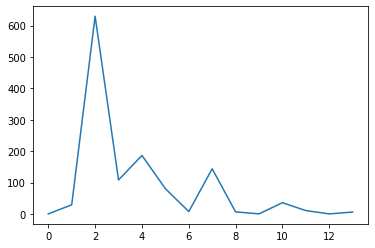

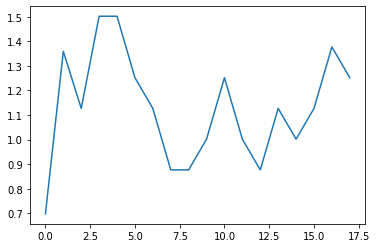

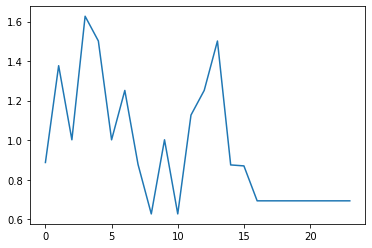

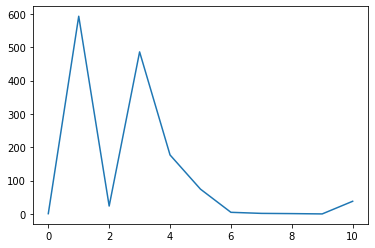

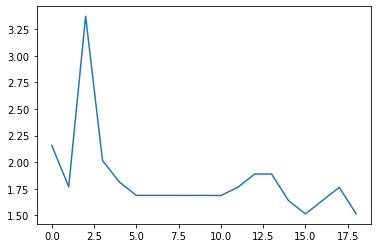

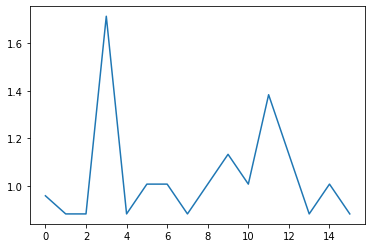

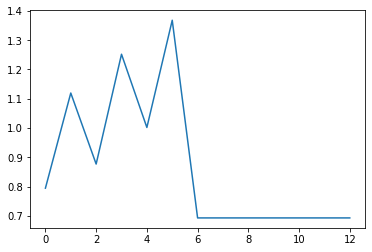

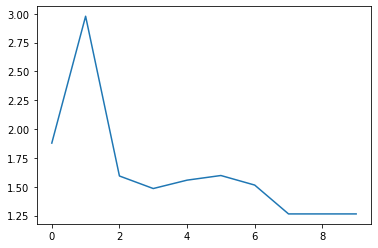

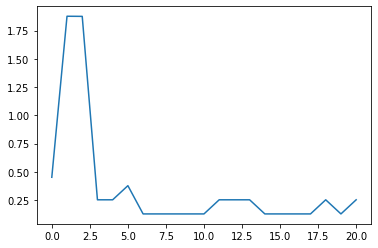

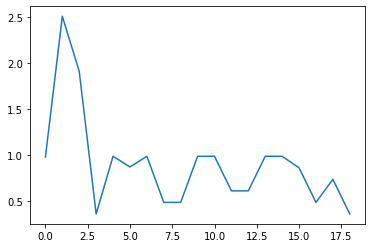

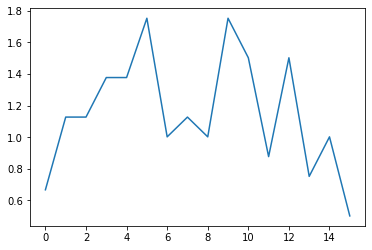

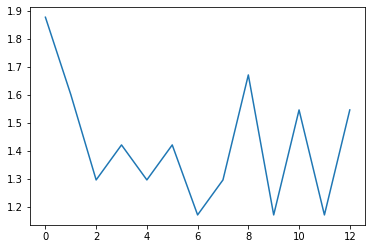

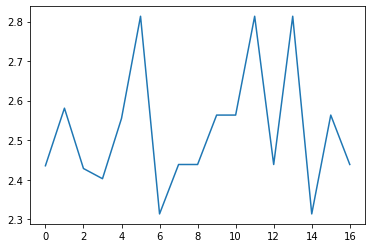

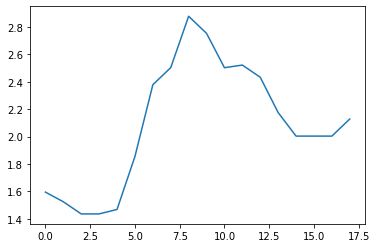

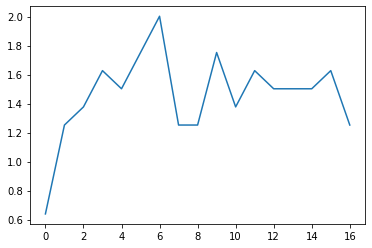

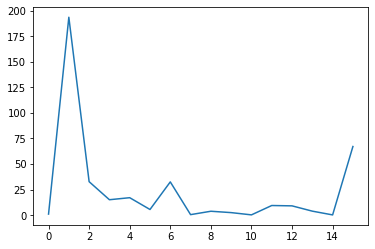

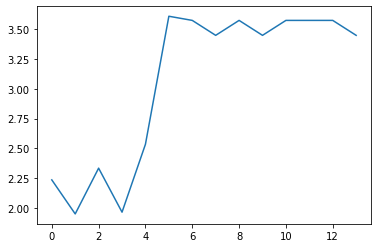

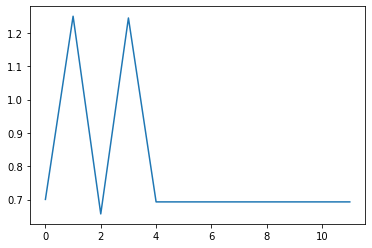

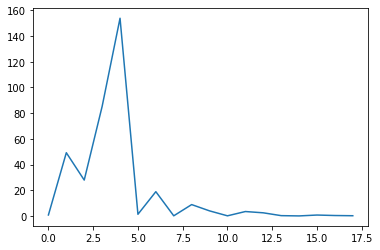

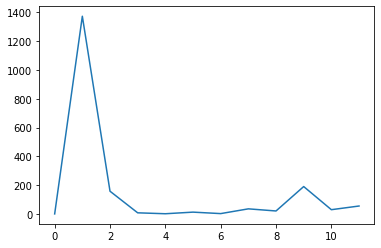

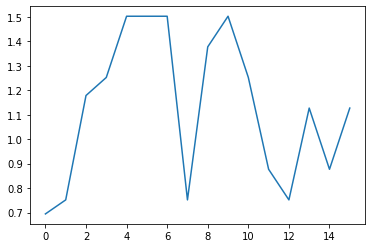

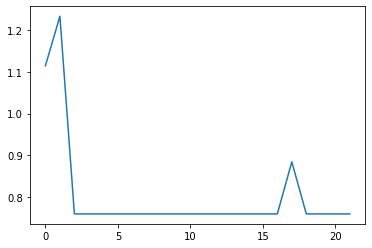

In [24]:
for task in losses:
    plt.plot(losses[task])
    plt.show()

In [22]:
tasks2 = {'CrowdFlower': 13}

In [23]:
mt_dev_dataloader = MultiTaskTestDataLoader(tasks2, split='dev', batch_size = 16, shuffle = True, num_workers = 6)
# test_loss = validate(mt_test_dataloader)

In [ ]:
# test_loss = validate(mt_test_dataloader)

In [ ]:
PATH = './mt_model_runs/mt_2.bin'
torch.save(mt_model.state_dict(), PATH)

Error in sys.excepthook:
Traceback (most recent call last):
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/linecache.py", line 46, in getlines
    return updatecache(filename, module_globals)
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/linecache.py", line 136, in updatecache
    with tokenize.open(fullname) as fp:
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/tokenize.py", line 392, in open
    buffer = _builtin_open(filename, 'rb')
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 2097877) is killed by signal: Killed. 

Original exception was:
Traceback (most recent call last):
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/jz17d/anaconda3/envs/torch/lib/python3.9/runpy.py", line 87, in _run_cod